In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Libraries
import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Dataset path
dataset_path = "/content/drive/My Drive/mhealth+dataset (1)/MHEALTHDATASET"

columns = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg_chest_1', 'ecg_chest_2',
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
    'magnet_ankle_x', 'magnet_ankle_y', 'magnet_ankle_z',
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
    'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z',
    'activity'
]

activity_labels = {
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}

def load_mhealth_data(path):
    all_data = []
    for file in sorted(os.listdir(path)):
        if file.endswith('.log'):
            df = pd.read_csv(os.path.join(path, file), delim_whitespace=True, header=None)
            df.columns = columns
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

df = load_mhealth_data(dataset_path)
scaler = StandardScaler()
df[columns[:-1]] = scaler.fit_transform(df[columns[:-1]])


In [4]:
def segment_data(data, window_size=80, step=40):
    X, y = [], []
    for start in range(0, len(data) - window_size, step):
        end = start + window_size
        segment = data.iloc[start:end]
        if len(segment['activity'].unique()) == 1:
            X.append(segment.drop('activity', axis=1).values)
            y.append(segment['activity'].iloc[0])
    return np.array(X), np.array(y)

X, y = segment_data(df)
y_encoded = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [5]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    return Add()([x, x_ff])

def build_transformer_rbfnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(64)(inputs)

    # Transformer Encoder
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

    # RBF Layer Simulation using Dense + Gaussian Activation
    def gaussian(x):
        return tf.exp(-tf.square(x))

    x = Dense(64)(x)
    x = Activation(gaussian)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_transformer_rbfnn_model(X.shape[1:], y_train.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80, 23)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80, 64)    │      1,536 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 80, 64)    │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 80, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 80, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 80, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 80, 64)    │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 80, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 80, 64)    │      4,160 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 64)    │          0 │ dense_3[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,320 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 12)        │      1,548 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,764 (385.80 KB)

 Trainable params: 98,764 (385.80 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

start = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks, verbose=1)
end = time.time()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 412ms/step - accuracy: 0.6670 - loss: 1.2506 - val_accuracy: 0.8145 - val_loss: 0.5103 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 86s 432ms/step - accuracy: 0.8067 - loss: 0.5081 - val_accuracy: 0.8736 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 437ms/step - accuracy: 0.8440 - loss: 0.3626 - val_accuracy: 0.8883 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 141s 431ms/step - accuracy: 0.8697 - loss: 0.3064 - val_accuracy: 0.8940 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 427ms/step - accuracy: 0.8778 - loss: 0.2803 - val_accuracy: 0.9052 - val_loss: 0.2245 - learning_rate: 0.0010
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 81s 422ms/step - accuracy: 0.8858 - loss: 0.2629 - val_accuracy: 0.9017 - val_loss: 0.2285 - learning_rate: 0.0010
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 83s 430ms/step - accuracy: 0.

187/187 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step
Classification Report:
                           precision    recall  f1-score   support

           Standing still       0.68      1.00      0.81       151
     Sitting and relaxing       0.76      0.96      0.85       140
               Lying down       0.76      1.00      0.86       150
                  Walking       0.90      0.98      0.94       157
          Climbing stairs       0.79      0.91      0.85       159
      Waist bends forward       0.80      0.90      0.85       150
Frontal elevation of arms       0.73      0.98      0.83       127
Knees bending (crouching)       0.83      0.87      0.85       149
                  Cycling       0.86      0.98      0.91       137
                  Jogging       0.85      1.00      0.92       148
                  Running       0.87      0.99      0.93       138
        Jump front & back       0.98      0.91      0.95      4374

                 accuracy                           0.92      

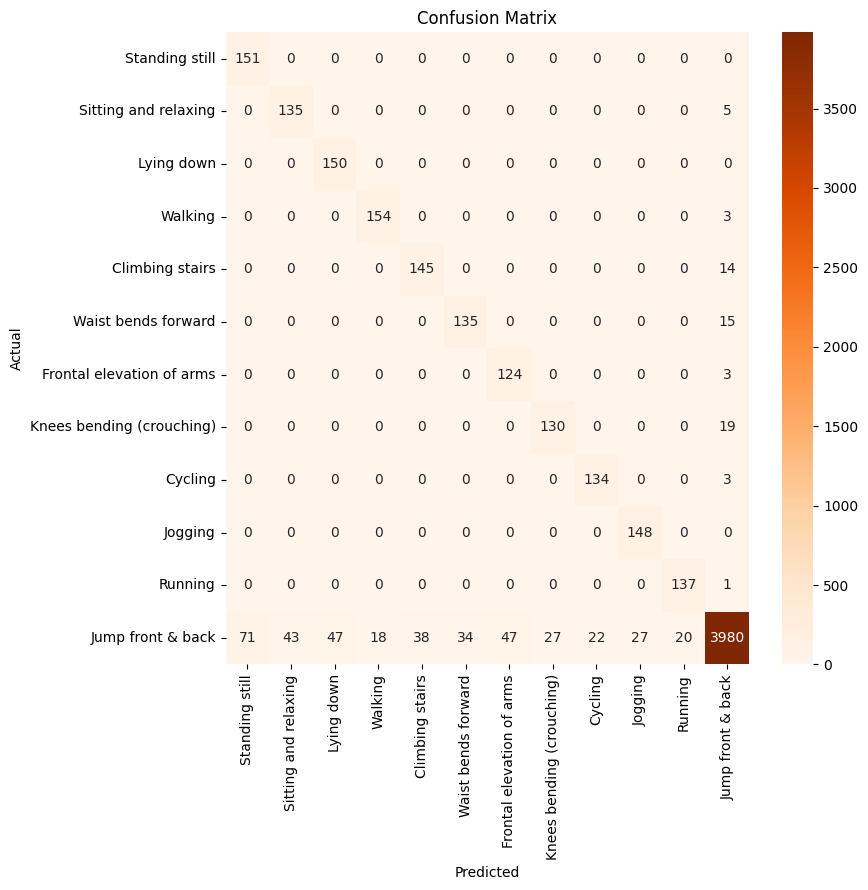

In [7]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification Report & Confusion Matrix
print("Classification Report:")
report = classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values())
print(report)

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=activity_labels.values(),
            yticklabels=activity_labels.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [8]:
accuracy = np.mean(y_pred_labels == y_true_labels)
mse = mean_squared_error(y_true_labels, y_pred_labels)
sensitivity = np.mean([report_dict['recall'] for report_dict in classification_report(y_true_labels, y_pred_labels, target_names=activity_labels.values(), output_dict=True).values() if isinstance(report_dict, dict)])

specificity_list = []
for i in range(len(activity_labels)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp_fn = cm.sum() - cm[:, i].sum()
    specificity_list.append(tn / fp_fn if fp_fn != 0 else 0)
specificity = np.mean(specificity_list)

print(f"✅ Accuracy     : {accuracy*100:.2f}%")
print(f"✅ Sensitivity  : {sensitivity:.4f}")
print(f"✅ Specificity  : {specificity:.4f}")
print(f"✅ MSE          : {mse:.4f}")
print(f"✅ Training Time: {end - start:.2f} sec")


✅ Accuracy     : 92.36%
✅ Sensitivity  : 0.9548
✅ Specificity  : 0.9821
✅ MSE          : 4.2130
✅ Training Time: 1682.51 sec


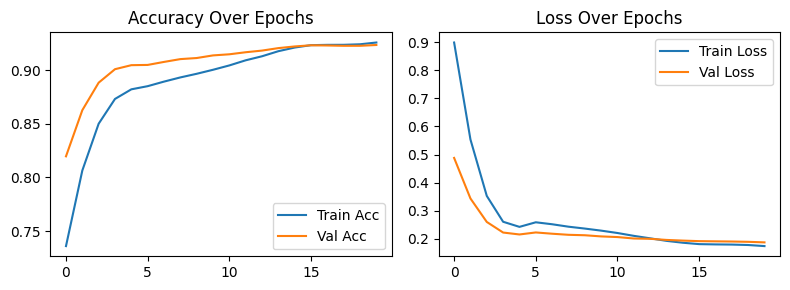

In [9]:
train_acc = savgol_filter(history.history['accuracy'], 9, 3)
val_acc = savgol_filter(history.history['val_accuracy'], 9, 3)
train_loss = savgol_filter(history.history['loss'], 9, 3)
val_loss = savgol_filter(history.history['val_loss'], 9, 3)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss Over Epochs")
plt.legend()
plt.tight_layout()
plt.show()


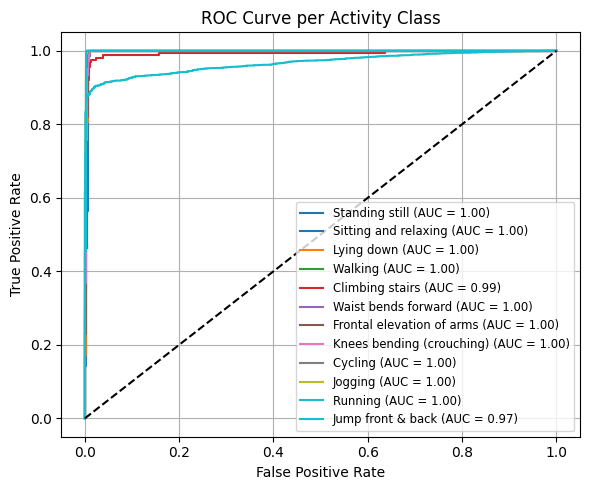

In [10]:
fpr, tpr, roc_auc = {}, {}, {}
n_classes = y_test.shape[1]
colors = plt.cm.get_cmap('tab10', n_classes).colors

plt.figure(figsize=(6, 5))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{activity_labels[i+1]} (AUC = {roc_auc[i]:.2f})", color=colors[i % len(colors)])

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Activity Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"\n🎯 Train Accuracy: {train_acc*100:.2f}% | Loss: {train_loss:.4f}")
print(f"\n📊 Val Accuracy  : {val_acc*100:.2f}%   | Loss: {val_loss:.4f}")
print(f"\n✅ Test Accuracy : {test_acc*100:.2f}% | Loss: {test_loss:.4f}")



🎯 Train Accuracy: 93.96% | Loss: 0.1444

📊 Val Accuracy  : 92.36%   | Loss: 0.1884

✅ Test Accuracy : 92.36% | Loss: 0.1884
